# 1. Settings

## 1-1. Important required libraries

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchsummary import summary
import itertools
from sklearn.metrics import confusion_matrix
import pickle
import time
import matplotlib.pyplot as plt
import utils

## 1-2. Hyperparameter

In [2]:
batch_size = 8
# learning_rate = 0.0001 # 1e-4
learning_rate = 0.00001 # 1e-5
# learning_rate = 0.000001 # 1e-6
epoch = 300

n_node = 1024 # customized last layer의 노드 수.
dropratio = 0.25 # 얼마나 드랍시킬지 inverse keeperatio

imgsize = 224

# 2. Data Loader

## 2-1. Train data

In [3]:
tarin_dir = "parrot_data_hierarchical_cls/train"
# Data Augmentaion
train_data = dset.ImageFolder(tarin_dir, transforms.Compose([ 
    transforms.CenterCrop(imgsize*2),  # ① CenterCrop(448)
    transforms.RandomCrop(imgsize),    # ② RandomCrop(224)
    transforms.RandomHorizontalFlip(), # ③ RandomHorizontalFlip
    transforms.RandomRotation(15),     # ④ RandomRoation(15)
    transforms.Resize(imgsize),        # ⑤ RandomResize(224)
    transforms.ToTensor()
    ]))
train_batch = data.DataLoader(train_data, batch_size = batch_size,
                              shuffle = True, num_workers = 2)

## 2-2. Validation data

In [4]:
val_dir = "parrot_data_hierarchical_cls/val"
val_data = dset.ImageFolder(val_dir, transforms.Compose([
    # 데이터를 일괄적으로 처리
    transforms.CenterCrop(imgsize),
    transforms.Resize(imgsize),
    transforms.ToTensor()
    ]))
val_batch = data.DataLoader(val_data, batch_size = batch_size,
                            shuffle = False, num_workers = 2)

## 2-3. Test data

In [5]:
test_dir = "parrot_data_hierarchical_cls/test"
test_data = dset.ImageFolder(test_dir, transforms.Compose([
    # 데이터를 일괄적으로 처리
    transforms.CenterCrop(imgsize),
    transforms.Resize(imgsize),
    transforms.ToTensor()
    ]))
test_batch = data.DataLoader(test_data, batch_size = batch_size,
                             shuffle = False, num_workers = 2)

## 2-4. Check data

In [6]:
nclass = len(train_data.classes)
print("<# of classes>\tTrain: %d, Val: %d, Test: %d"
      %(len(train_data.classes),len(val_data.classes),len(test_data.classes)))
print(train_data.class_to_idx)
print("<# of data>\tTrain: %d, Val: %d, Test: %d"
      %(train_data.__len__(), val_data.__len__(), test_data.__len__()))

# print(train_data.classes)
# print(val_data.classes)
# print(test_data.classes)

<# of classes>	Train: 2, Val: 2, Test: 2
{'GroupA': 0, 'GroupB': 1}
<# of data>	Train: 1531, Val: 324, Test: 328


# 3. Model

## 3-1. Pretrained VGG Model

In [7]:
vgg = models.vgg16(pretrained=True) ##########

for name, module in vgg.named_children():
    print(name)
    
# print(list(vgg.children())[0]) # convolution layer
# print(list(vgg.children())[-1]) # fully connected layer

for i in range(len(list(vgg.children()))):
    print(i, list(vgg.children())[i])

print(list(vgg.children())[0][5])

features
avgpool
classifier
0 Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (1

## 3-2. Customized Fully Model

In [8]:
base_dim = 64
fsize = int(imgsize/32)

print(fsize)
print(8*base_dim * fsize * fsize)
print(n_node)

class CustomVGG(nn.Module):
    def __init__(self):
        super(CustomVGG, self).__init__()
        # [0]: features(conv), [1]: classifier(fc)
        self.layer0 = nn.Sequential(
            *list(vgg.children())[0]
        ) # 3×224×224 → 512×7×7
        
        self.layer1 = nn.Sequential(
            nn.Linear((8*base_dim * fsize * fsize), n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, nclass)
        ) # 512×7×7 → 1024 → 1024 → 2
        
        # weight initialization
        for m in self.layer1.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
                
    def forward(self, x):
        # layer0의 사이즈를 프린트하여 알아낼 수 있음(batchsize, x, x, x)
        out = self.layer0(x)
        out = out.view(out.size(0), -1) # 1열로 피기
        out = self.layer1(out)
        return out

7
25088
1024


In [9]:
# base_dim = 64
# fsize = int(imgsize/32)

# print(fsize)
# print(8*base_dim * fsize * fsize)
# print(n_node)

# class CustomVGG(nn.Module):
#     def __init__(self):
#         super(CustomVGG, self).__init__()
#         # [0]: features(conv), [1]: classifier(fc)
#         self.layer0 = nn.Sequential(
#             *list(vgg.children())[0][:17]
#         ) # 3×224×224 → 256×28×28
        
#         self.layer1= nn.Sequential(
#             *list(vgg.children())[0][17:]
#         ) # 256×28×28→ 512×7×7
        
#         self.layer2 = nn.Sequential(
#             nn.Linear((8*base_dim * fsize * fsize), n_node),
#             nn.ReLU(),
#             nn.Dropout2d(dropratio),
            
#             nn.Linear(n_node, n_node),
#             nn.ReLU(),
#             nn.Dropout2d(dropratio),
            
#             nn.Linear(n_node, nclass)
#         ) # 512×7×7 → 1024 → 1024 → 2
        
#         # weight initialization
#         for m in self.layer1.modules():
#             if isinstance(m, nn.Conv2d):
#                 init.kaiming_normal(m.weight.data)
#                 m.bias.data.fill_(0)
#             if isinstance(m, nn.Linear):
#                 init.kaiming_normal(m.weight.data)
#                 m.bias.data.fill_(0)
        
#         for m in self.layer2.modules():
#             if isinstance(m, nn.Conv2d):
#                 init.kaiming_normal(m.weight.data)
#                 m.bias.data.fill_(0)
#             if isinstance(m, nn.Linear):
#                 init.kaiming_normal(m.weight.data)
#                 m.bias.data.fill_(0)
                
#     def forward(self, x):
#         # layer0의 사이즈를 프린트하여 알아낼 수 있음(batchsize, x, x, x)
#         out = self.layer0(x)
#         out = self.layer1(out)
#         out = out.view(out.size(0), -1) # 1열로 피기
#         out = self.layer2(out)
#         return out

## 3-3. Model on GPU

In [10]:
def pytorch_gpu_check(gpu_num = 0):
    # GPU 인식 여부 확인 및 GPU 할당 변경하기
    device = torch.device(f'cuda:{gpu_num}' if torch.cuda.is_available() else 'cpu') # 원하는 GPU 번호 사용
    torch.cuda.set_device(device)  # change allocation of current GPU
    print('Current cuda device:', torch.cuda.current_device())  # check
    print(torch.cuda.get_device_name(gpu_num))
    # 사용방법: 명령어.to(device) → GPU환경, CPU환경에 맞춰서 동작
    return device

In [11]:
gpu_num = 0
device = pytorch_gpu_check(gpu_num=gpu_num)
model = CustomVGG().to(device)

for params in model.layer0.parameters():
    params.required_grad = False ##########
    
for params in model.layer1.parameters():
    params.required_grad = True
    
# for params in model.layer2.parameters():
#     params.required_grad = True

Current cuda device: 0
GeForce RTX 2060 SUPER


C:\Users\SIWON\anaconda3\envs\parrot\lib\site-packages\ipykernel_launcher.py:34: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [12]:
for name in model.children():
    print(name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [13]:
# img = torch.rand([1, 3, 224, 224])
# img = img.to(device)
# img.size()

# model(img).size()

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

# 4. Optimizer & Loss

In [14]:
loss_func = nn.CrossEntropyLoss() # 분류문제 → CrossEntropy
# loss_func = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# layers = itertools.chain(model.layer1.parameters(), model.layer2.parameters())
# optimizer = optim.Adam(layers, lr=learning_rate)

# 5. Train

In [15]:
total_time = 0
disp_step = 10

to_train = True
if (to_train == False):
    netname = './nets/parrot_vgg16_1st_cls'
    model = torch.load(netname)
else:
    print("3 layer, n_node: %d, dropratio: %.2f" %(n_node, dropratio))
    model.eval() # evaluation(test) mode로 바꾸기 → dropout, batch normalization에 영향을 줌.
    train_corr = utils.ComputeCorr(train_batch, model)
    val_corr = utils.ComputeCorr(val_batch, model)
    test_corr = utils.ComputeCorr(test_batch, model)
    print("Correct of train: %.2f, val: %.2f, test: %.2f"
         %(train_corr, val_corr, test_corr))
    model.train()
    
    netname = './nets/parrot_vgg16_1st_cls'
    
    # graph 그리기
    x_epoch = []
    y_train_err = []
    y_val_err = []
    y_test_err = []
    
    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)
    y_val_err.append(100.0-val_corr)
    y_test_err.append(100.0-test_corr)
    
#     # 학습을 재시작한다면
#     netname = '../nets/media_pre_vgg19.pkl'
#     model = torch.load(netname)
#     # 파라미터 학습 여부 결정
#     for params in model.layer0.parameters():
#         params.required_grad = False    
#     for params in model.layer1.parameters():
#         params.required_grad = True
#     for i in range(34, epoch):
        
    # 재시작 하지않는다면
    for i in range(epoch):
        start_time = time.time()
#         print("%d.." %i),
        for img, label in train_batch:
            img = Variable(img).to(device)
            label = Variable(label).to(device)
            
            optimizer.zero_grad()
            output = model(img)
            loss = loss_func(output, label)
            loss.backward()    
            optimizer.step()
            
        end_time = time.time()
        duration = end_time - start_time
        total_time += duration
        if(i%disp_step == 0) or (i == epoch-1):
            torch.save(model, netname+'_%d.pkl'%i, )
            print("\n[%d/%d] loss: %.3f, " %(i, epoch-1, (loss.cpu()).data.numpy()))
            
            # evaluation(test) mode로 바꾸기 → dropout, batch normalization에 영향을 줌.
            model.eval()

            # train, val, train accr
            train_corr = utils.ComputeCorr(train_batch, model)
            val_corr = utils.ComputeCorr(val_batch, model)
            test_corr = utils.ComputeCorr(test_batch, model)
            print("Correct of train: %.2f, val: %.2f, test: %.2f, "
                 %(train_corr, val_corr, test_corr))
            model.train()
            print("time: %.2f sec.." %(total_time))

            # graph 그리기
            x_epoch.append(i+1)
            y_train_err.append(100.0-train_corr)
            y_val_err.append(100.0-val_corr)
            y_test_err.append(100.0-test_corr)
    print("Total time: %.2f sec" %total_time)

3 layer, n_node: 1024, dropratio: 0.25
Correct of train: 48.01, val: 48.15, test: 47.26

[0/299] loss: 0.462, 
Correct of train: 97.13, val: 98.46, test: 98.78, 
time: 21.06 sec..

[10/299] loss: 0.003, 
Correct of train: 99.41, val: 100.00, test: 99.70, 
time: 237.02 sec..

[20/299] loss: 0.000, 
Correct of train: 99.48, val: 100.00, test: 99.70, 
time: 457.72 sec..

[30/299] loss: 0.000, 
Correct of train: 99.54, val: 100.00, test: 99.70, 
time: 677.93 sec..

[40/299] loss: 0.000, 
Correct of train: 99.48, val: 100.00, test: 99.70, 
time: 898.05 sec..

[50/299] loss: 0.000, 
Correct of train: 99.15, val: 98.77, test: 98.48, 
time: 1118.42 sec..

[60/299] loss: 0.000, 
Correct of train: 99.87, val: 100.00, test: 99.70, 
time: 1338.22 sec..

[70/299] loss: 0.002, 
Correct of train: 99.54, val: 99.69, test: 99.70, 
time: 1557.70 sec..

[80/299] loss: 0.000, 
Correct of train: 99.93, val: 99.38, test: 99.70, 
time: 1777.85 sec..

[90/299] loss: 0.000, 
Correct of train: 99.48, val: 98.77

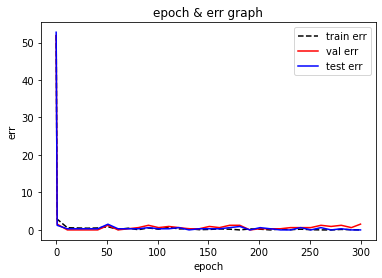

In [16]:
# epoch-err curve
if (to_train):
    plt.plot(x_epoch, y_train_err, color='black', label='train err', linestyle='--')
    plt.plot(x_epoch, y_val_err, color='red', label='val err')
    plt.plot(x_epoch, y_test_err, color='blue', label='test err')
    
    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch & err graph')
    plt.legend(loc='upper right')
    plt.show()

In [17]:
train_info = {
    'x_epoch': x_epoch,
    'y_train_err': y_train_err,
    'y_val_err': y_val_err,
    'y_test_err': y_test_err
}
# save train info
with open(netname+"_train_info.pkl", 'wb') as f:
    pickle.dump(train_info, f, pickle.HIGHEST_PROTOCOL)

# 6. Evaluation for test data

In [18]:
def arr_softmax(arr):
    # 합
    sum = 0.0
    for i in range(len(arr)):
        sum = sum + np.exp(arr[i])

    for i in range(len(arr)):
        arr[i] = np.exp(arr[i]) / sum
    return arr

def ComputePredProb(i_batch, i_model, i_classes, i_batch_size=32):
    # total probability 리턴. class 개수 필요.
    # 1. 전체 길이 계산
    n = 0
    for i, [imgs, _] in enumerate(i_batch):
        n += len(imgs)

    nclass = len(i_classes)

    # 2. pred, true
    pred_1d = np.ndarray(n, dtype=int)  # 모든 n개 영상에 대한 prediction
    label_1d = np.ndarray(n, dtype=int)  # 모든 n개 영상에 대한 true label
    probability_1d = np.ndarray(n, dtype=float)
    probability_total_2d = np.ndarray((n, nclass), dtype=float)  # 모든 n개 영상에 대한 모든 클래스의 probability (n x nclass)
    for i, [imgs, labels] in enumerate(i_batch):
        torch.no_grad()
        x = Variable(imgs).cuda()  # back prop. 안하고, forward prop. 만 하겠다.
        y_ = Variable(labels).cuda()

        output = i_model(x)
        _, output_index = torch.max(output, 1)

        # 1) pred
        output_index_cpu = (output_index.data.cpu()).numpy()  # cpu()
        y_cpu = (y_.data.cpu()).numpy()  # cpu()

        size = len(x)
        #         s = (i*i_batch_size)
        #         e = s + size
        for k in range(size):
            pred_1d[i * i_batch_size + k] = int(output_index_cpu[k])
            label_1d[i * i_batch_size + k] = int(y_cpu[k])

        # 2) probability
        prob_arr = (output.cpu()).data.numpy()
        for k in range(size):
            prob = arr_softmax(prob_arr[k])
            idx = pred_1d[i * i_batch_size + k]
            probability_1d[i * i_batch_size + k] = prob[idx]

            # print(prob.size())
            probability_total_2d[i * i_batch_size + k, :] = prob  # (n x nclass)

    return pred_1d, label_1d, probability_1d, probability_total_2d

def matric4classifer(cm, classes):
    # Confusion matrix 로 accuracy, precision, recal, F1 score 계산 및 출력
    n = len(classes)
    acc = np.ndarray((n), dtype=float)
    pre = np.ndarray((n), dtype=float)
    rec = np.ndarray((n), dtype=float)
    f1 = np.ndarray((n), dtype=float)

    '''
    TP: cm[i, i]
    FP: cm[:i-1, i] + cm[i+1:, i]
    FN: cm[i, :i-1] + cm[i, i+1:]
    TN: cm[:i-1, :i-1] + cm[i+1:, i+1:]
    '''
    print("Label: \t acc  |\t pre  |\t rec  |\t f1")
    # 각 클래스마다
    for i, c in enumerate(classes):
        # 1. Accuracy = (TP+TN) / (TP+FP+FN+TN)
        if (i - 1 < 0):
            tn1 = 0
        else:
            tn1 = np.sum(cm[:i, :i])  # [:i] '0 ~ i-1' 까지

        if (i + 1 >= n):
            tn2 = 0
        else:
            tn2 = np.sum(cm[i + 1:, i + 1:])  # [i:] 'i~끝' 까지

        acc[i] = float(cm[i, i] + tn1 + tn2) / float(np.sum(cm[:, :]))

        # 2. Precision = TP / (TP+FP)
        pre[i] = float(cm[i, i]) / float(np.sum(cm[:, i]))
        # 3. Recall = TP / (TP+FN)
        rec[i] = float(cm[i, i]) / float(np.sum(cm[i, :]))
        # 4. F1 Score = 2 * (precision*recall) / (precision+recall)
        if (float(pre[i] + rec[i]) == 0):
            f1[i] = 0.0
        else:
            f1[i] = 2.0 * float(pre[i] * rec[i]) / float(pre[i] + rec[i])

        print(" %s:\t %.2f |\t %.2f |\t %.2f |\t %.2f" % (c, acc[i], pre[i], rec[i], f1[i]))

    # total matric
    total_acc = np.average(acc)
    total_pre = np.average(pre)
    total_rec = np.average(rec)
    total_f1 = np.average(f1)

    print("\n*accuracy: %.3f, precision: %.3f, recall: %.3f, *f1 score: %.3f"
        % (total_acc, total_pre, total_rec, total_f1))

    del acc, pre, rec, f1
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 2),  # 반올림
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def EvaluateClassifier(i_batch, i_model, i_classes, i_batch_size=32, label_name=True):
    # --- 1. Confusion matrix 그리기 ---
    # 1-1. pred, true 배열 구하기
    # 전체 길이 계산
    n = 0
    for i, [imgs, _] in enumerate(i_batch):
        n += len(imgs)

    pred_1d, label_1d, prob_1d, prob_2d = ComputePredProb(i_batch, i_model, i_classes, i_batch_size)

    # 1-2. confusion matrix 계산
    # print("size of pred: %d, true: %d" %(len(pred_1d), len(label_1d)))
    cnf_mat = confusion_matrix(label_1d, pred_1d)
    # del pred_1d, label_1d
    
    if(label_name==False):
        i_classes = np.array(range(len(i_classes)))
    
    plt.figure()
    plot_confusion_matrix(cnf_mat, classes=i_classes, normalize=False, title='Confusion matrix, without normalization')
    plt.show()
    
    plt.figure()
    plot_confusion_matrix(cnf_mat, classes=i_classes, normalize=True, title='Normalized confusion matrix')
    plt.show()
    
    # --- 2. Accr, F1, Precision, Recall ---
    matric4classifer(cnf_mat, i_classes)

    return pred_1d, label_1d, prob_1d

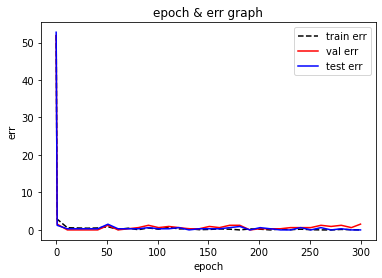

In [19]:
# # 학습 결과 정보 불러오기
# netname = './nets/parrot_vgg16_1st_cls'

# with open(netname+"_train_info.pkl", 'rb') as f:
#     train_info = pickle.load(f)

# x_epoch = train_info['x_epoch']
# y_train_err = train_info['y_train_err']
# y_val_err = train_info['y_val_err']
# y_test_err = train_info['y_test_err']

# plt.plot(x_epoch, y_train_err, color='black', label='train err', linestyle='--')
# plt.plot(x_epoch, y_val_err, color='red', label='val err')
# plt.plot(x_epoch, y_test_err, color='blue', label='test err')

# plt.xlabel('epoch')
# plt.ylabel('err')
# plt.title('epoch & err graph')
# plt.legend(loc='upper right')
# plt.show()

In [24]:
# 모델 불러오기
try:
    # 미리 학습시킨 네트워크의 파라미터 집합 [피클]
    model = torch.load('nets/parrot_vgg16_1st_cls_130.pkl')
    print("model loaded")
except:
    print("model not loaded")

model loaded


Confusion matrix, without normalization


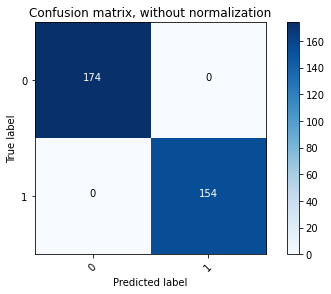

Normalized confusion matrix


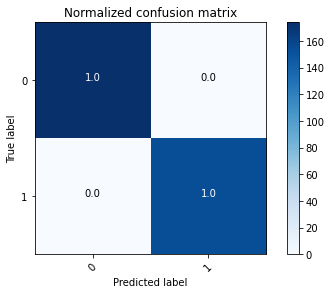

Label: 	 acc  |	 pre  |	 rec  |	 f1
 0:	 1.00 |	 1.00 |	 1.00 |	 1.00
 1:	 1.00 |	 1.00 |	 1.00 |	 1.00

*accuracy: 1.000, precision: 1.000, recall: 1.000, *f1 score: 1.000


In [25]:
model.eval()
_, _, _ = EvaluateClassifier(test_batch, model, test_data.classes, batch_size, label_name=False)

---

In [22]:
# ================================================================
# true & false predicted images 시각화
# ================================================================
# * 주의! dropout or batch normalization 을 적용한 모델이라면,
#  반드시 model.eval() <--> model.train()
#  evaluation mode 로 변경한 후 함수 호출할 것

# i_n: 몇 개 예를 보여줄 지
def VisTFPred(i_batch, i_model, i_classes, i_batch_size=32, i_n=3):
    # 전체 길이 계산
    nclass = len(i_classes)
    len_data = 0
    for i, [imgs, _] in enumerate(i_batch):
        len_data += len(imgs)

        # 0. true, false list array 할당
    tlist = np.ndarray((nclass, len_data))  # true predicted list
    flist = np.ndarray((nclass, len_data))  # false predicted list
    tcnt = np.ndarray((nclass))
    fcnt = np.ndarray((nclass))

    # 0. 1 채우기
    for i in range(nclass):
        tcnt[i] = 0
        fcnt[i] = 0

    total_img = []
    total_label = []
    total_pred = []
    total_pred_prob = []

    # batch 단위로
    for i, [imgs, labels] in enumerate(i_batch):
        # 1. model(img)
        torch.no_grad()
        x = Variable(imgs).cuda()  ## back prop. 안하고, forward prop. 만 하겠다.
        y_ = Variable(labels).cuda()

        output = i_model(x)
        _, output_index = torch.max(output, 1)

        output_index_cpu = output_index.data.cpu()
        y_cpu = y_.data.cpu()

        pred_prob = (output.cpu()).data.numpy()

        size = len(x)
        s = (i * i_batch_size)
        e = s + size

        for k in range(size):
            # 2. total img, label 갱신
            # label_1d[i*i_batch_size + k] = int(y_cpu[k])
            # pred_1d[i*i_batch_size + k] = int(output_index_cpu[k])
            curr_img = transforms.ToPILImage()(imgs[k])
            curr_y = int(y_cpu[k])
            curr_pred = int(output_index_cpu[k])

            total_img.append(curr_img)
            total_label.append(curr_y)
            total_pred.append(curr_pred)

            total_pred_prob.append(arr_softmax(pred_prob[k]))

            # print(pred_prob[k]),
            # print("pred: %d (%.2f), true: %d" %(curr_pred, pred_prob[k][curr_pred], curr_y))
            # print("sum: %.2f" %sum(pred_prob[k]))

            # 3. label, pred 비교 -> tlist, flist 갱신
            if (curr_y == curr_pred):
                idx = int(tcnt[curr_y])
                tlist[curr_y][idx] = i * i_batch_size + k
                tcnt[curr_y] += 1
            else:
                idx = int(fcnt[curr_y])
                flist[curr_y][idx] = i * i_batch_size + k
                fcnt[curr_y] += 1

    # 4. visualize
    for k, category in enumerate(i_classes):
        print("Category: %s" % (category))
        tnew_n = i_n
        fnew_n = i_n

        # 3. idx
        if (tcnt[k] == 0):
            tnew_n = 0
        elif (tcnt[k] < i_n):  # 요청하는 개수보다 전체 개수가 더 적으면
            # trandidx = np.random.choice(int(tcnt[k]), int(tcnt[k]), replace=False)
            trandidx = range(0, int(tcnt[k]))  # 0~tcnt[k]
            tnew_n = int(tcnt[k])
        else:
            # trandidx = np.random.choice(int(tcnt[k]), i_n, replace=False)
            trandidx = range(0, i_n)  # 0~i_n

        if (fcnt[k] == 0):
            fnew_n = 0
        elif (fcnt[k] < i_n):
            # frandidx = np.random.choice(int(fcnt[k]), int(fcnt[k]), replace=False)
            frandidx = range(0, int(fcnt[k]))  # 0~fcnt[k]
            fnew_n = int(fcnt[k])
        else:
            # frandidx = np.random.choice(int(fcnt[k]), i_n, replace=False)
            frandidx = range(0, i_n)  # 0~i_n

        # 4. n 개 true, false 그리기
        # 1) true predicted image 그리기
        print(" True predicted images/total %s category: %d / %d" % (category, tcnt[k], tcnt[k] + fcnt[k]))
        if (tnew_n != 0):
            for i in trandidx:
                # img, label = i_batch.dataset[int(tlist[k][i])]
                idx = int(tlist[k][i])
                img = total_img[idx]
                y = total_label[idx]
                pred = total_pred[idx]

                print("Predicted probability:"),
                print(total_pred_prob[idx])
                plt.title("Pred: %d(%s) %.2f / True: %d(%s)" % (
                pred, i_classes[pred], total_pred_prob[idx][pred] * 100.0, y, i_classes[y]))
                plt.imshow(img)
                plt.show()

        # 2) false predicted image 그리기
        print(" False predicted images/total %s category: %d / %d" % (category, fcnt[k], tcnt[k] + fcnt[k]))
        if (fnew_n != 0):
            for i in frandidx:
                # img, label = i_batch.dataset[int(flist[k][i])]
                idx = int(flist[k][i])
                img = total_img[idx]
                y = total_label[idx]
                pred = total_pred[idx]

                print("Predicted probability:"),
                print(total_pred_prob[idx])
                plt.title("Pred: %d(%s) %.2f / True: %d(%s)" % (
                pred, i_classes[pred], total_pred_prob[idx][pred] * 100.0, y, i_classes[y]))
                plt.imshow(img)
                plt.show()

    del tlist, flist, tcnt, fcnt

Category: GroupA
 True predicted images/total GroupA category: 174 / 174
Predicted probability:
[1.000000e+00 1.679835e-39]


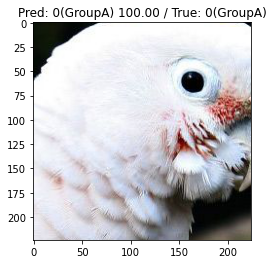

Predicted probability:
[1.0000000e+00 5.3915296e-20]


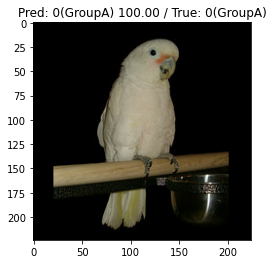

 False predicted images/total GroupA category: 0 / 174
Category: GroupB
 True predicted images/total GroupB category: 154 / 154
Predicted probability:
[4.481831e-11 1.000000e+00]


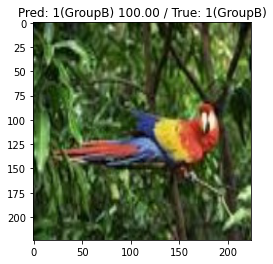

Predicted probability:
[8.3182694e-22 1.0000000e+00]


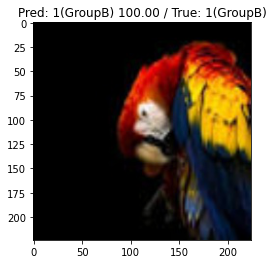

 False predicted images/total GroupB category: 0 / 154


In [23]:
VisTFPred(test_batch, model, test_data.classes, batch_size, i_n=2)